## Imports

In [1]:
import matplotlib.pyplot as plt
import talib as ta
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random, datetime, os

In [2]:
%load_ext tensorboard

## Obtendo os dados

In [3]:
df = pd.read_csv('candles.csv') 
df

,from,to,open,close,min,max,date
0,1631674860,1631674920,1.180770,1.180770,1.180750,1.180790,2021-Sep-15 00:01
1,1631674920,1631674980,1.180780,1.180745,1.180730,1.180805,2021-Sep-15 00:02
2,1631674980,1631675040,1.180750,1.180685,1.180650,1.180750,2021-Sep-15 00:03
3,1631675040,1631675100,1.180690,1.180680,1.180665,1.180710,2021-Sep-15 00:04
4,1631675100,1631675160,1.180685,1.180680,1.180675,1.180705,2021-Sep-15 00:05
...,...,...,...,...,...,...,...
366518,1662481800,1662481860,0.991065,0.991045,0.991035,0.991275,2022-Sep-06 13:30
366519,1662481860,1662481920,0.991055,0.991105,0.991025,0.991255,2022-Sep-06 13:31
366520,1662481920,1662481980,0.991095,0.990995,0.990925,0.991225,2022-Sep-06 13:32
366521,1662481980,1662482040,0.990995,0.990835,0.990755,0.991055,2022-Sep-06 13:33


## Fazendo o tratamento dos dados

In [4]:
df = df.drop(columns = {'from','to','date'})

In [5]:
SEQ_LEN = 5
FUTURE_PERIOD_PREDICT = 1

In [6]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [7]:
def preprocess_df(df):
      
    df = df.drop(columns='future')
   
    scaler = MinMaxScaler()
    indexes = df.index
    df_scaled = scaler.fit_transform(df)

    df = pd.DataFrame(df_scaled,index = indexes)

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)

    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]]) 

    random.shuffle(sequential_data)

    buys = []
    sells = []

    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target]) 
        elif target == 1:
            buys.append([seq, target]) 

    random.shuffle(buys)  
    random.shuffle(sells)

    lower = min(len(buys), len(sells))  

    buys = buys[:lower]  
    sells = sells[:lower]  

    sequential_data = buys+sells
    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:  
        X.append(seq) 
        y.append(target) 

    return np.array(X), y 

In [8]:
def treatment_data(df):
    
    df.isnull().sum().sum() # there are no nans
    df.fillna(method="ffill", inplace=True)
    df = df.loc[~df.index.duplicated(keep = 'first')]

    df['future'] = df["close"].shift(-FUTURE_PERIOD_PREDICT)
    

    df['%K'], df['%D'] = ta.STOCH(df['max'], df['min'], df['close'], 14, 3, 0, 3, 0)

    df['EMA_9'] = ta.EMA(df['close'], 9)
    df['EMA_21'] = ta.EMA(df['close'], 21)
    
    df['rsi'] = ta.RSI(df['close'], timeperiod=14)
    
    df = df.drop(columns = {'open','min','max'})
    
    df = df.dropna()
    dataset = df.fillna(method="ffill")
    dataset = dataset.dropna()

    dataset.sort_index(inplace = True)

    main_df = dataset

    main_df.fillna(method="ffill", inplace=True)
    main_df.dropna(inplace=True)

    main_df['target'] = list(map(classify, main_df['close'], main_df['future']))

    main_df.dropna(inplace=True)

    main_df['target'].value_counts()

    main_df.dropna(inplace=True)

    main_df = main_df.astype('float32')
    
    return main_df

In [9]:
treatment_data(df)

,close,future,%K,%D,EMA_9,EMA_21,rsi,target
20,1.180795,1.180845,86.840958,85.394798,1.180729,1.180693,55.140999,1.0
21,1.180845,1.180845,91.673988,87.372543,1.180752,1.180707,60.102959,0.0
22,1.180845,1.180895,95.987015,91.500656,1.180770,1.180719,60.102959,1.0
23,1.180895,1.180940,95.570061,94.410355,1.180795,1.180735,64.639191,1.0
24,1.180940,1.180940,94.702171,95.419746,1.180824,1.180754,68.149155,0.0
...,...,...,...,...,...,...,...,...
366517,0.991085,0.991045,61.836006,43.934704,0.990991,0.991017,51.243374,0.0
366518,0.991045,0.991105,69.679146,59.792664,0.991002,0.991019,50.337955,1.0
366519,0.991105,0.990995,67.450981,66.322044,0.991022,0.991027,51.716084,0.0
366520,0.990995,0.990835,63.921570,67.017235,0.991017,0.991024,49.029800,0.0


## Criando o modelo e treinamento

In [10]:
def create_model(shape):
    
    model = Sequential()
    model.add(LSTM(128, kernel_regularizer=l2(1e-5), input_shape=(shape), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(128, kernel_regularizer=l2(1e-5), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(LSTM(128, kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32, kernel_regularizer=l2(1e-5), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))
   
    return model

In [11]:
def train_data(df):
     
    main_df = treatment_data(df)  
   
    times = sorted(main_df.index.values)
    last_5pct = sorted(main_df.index.values)[-int(0.1*len(times))]

    validation_main_df = main_df[(main_df.index >= last_5pct)]
    main_df = main_df[(main_df.index < last_5pct)]

    train_x, train_y = preprocess_df(main_df)
    validation_x, validation_y = preprocess_df(validation_main_df)
    
    train_y = np.asarray(train_y)
    validation_y = np.asarray(validation_y)
    train_x = np.asarray(train_x)
    validation_x = np.asarray(validation_x)

    LEARNING_RATE = 0.0001
    EPOCHS = 40
    BATCH_SIZE = 16
    
    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)
    
    model = create_model(train_x.shape[1:])

    opt = Adam(learning_rate=LEARNING_RATE, decay=5e-5)

    model.summary()
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
          )

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = TensorBoard(logdir, histogram_freq=1)

    filepath = "models/Next_Candle"
    checkpoint = ModelCheckpoint("{}.h5".format(filepath), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

          
    hist = model.fit(
        train_x, 
        train_y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(validation_x, validation_y),
        callbacks=[tensorboard, checkpoint, earlyStoppingCallback],
        #workers = 2,
        #use_multiprocessing=True,
        )

       
    hist.history

    #for key in hist.history:
        #  print(key)

    return filepath, hist

In [12]:
_,history = train_data(df)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            69120     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 batch_normalization (BatchN  (None, 5, 128)           512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 5, 128)           512       
 hNormalization)                                        

Epoch 21/40
22032/22034 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.5067
Epoch 21: val_accuracy did not improve from 0.51228
22034/22034 [==============================] - 416s 19ms/step - loss: 0.6943 - accuracy: 0.5067 - val_loss: 0.6942 - val_accuracy: 0.5116
Epoch 22/40
22033/22034 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.5061
Epoch 22: val_accuracy did not improve from 0.51228
22034/22034 [==============================] - 441s 20ms/step - loss: 0.6943 - accuracy: 0.5061 - val_loss: 0.6942 - val_accuracy: 0.5117
Epoch 23/40
22033/22034 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.5071
Epoch 23: val_accuracy did not improve from 0.51228
22034/22034 [==============================] - 451s 20ms/step - loss: 0.6943 - accuracy: 0.5071 - val_loss: 0.6941 - val_accuracy: 0.5122
Epoch 24/40
22034/22034 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5078
Epoch 24: val_accuracy did

## Resultados

In [13]:
%tensorboard --logdir logs

In [14]:
%matplotlib inline

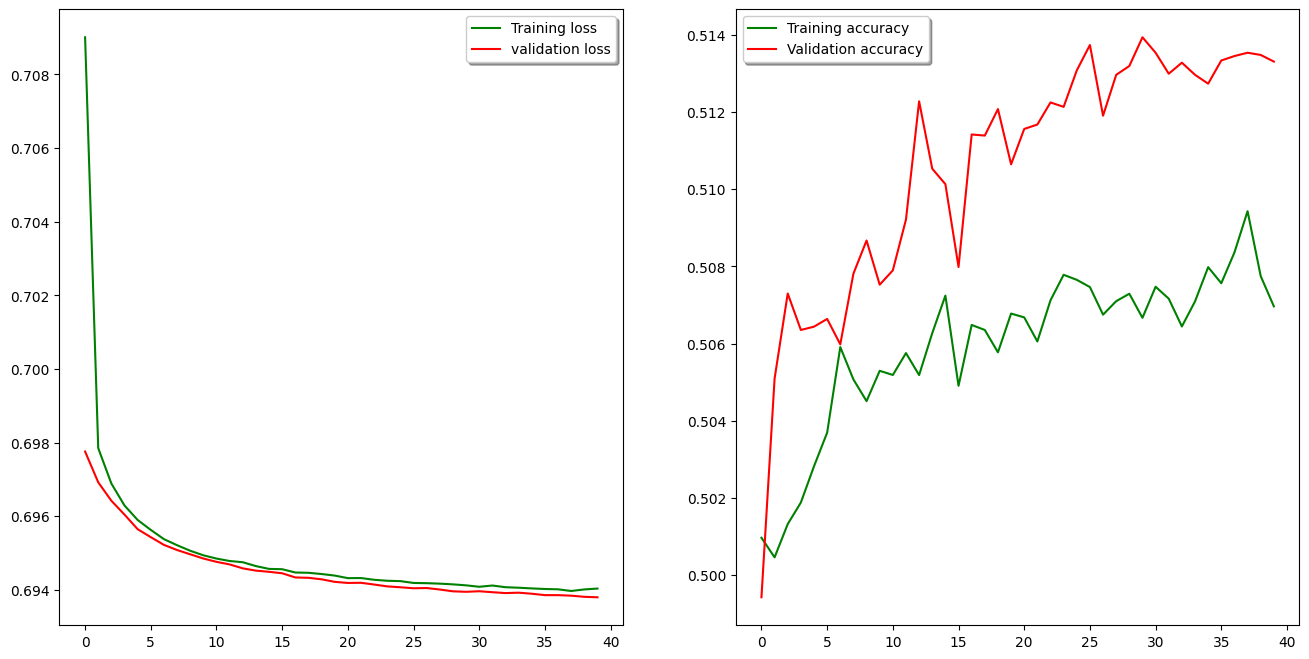

In [15]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='g', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)